In [1]:
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt

global problem_size
global num_of_evaluation


#Các hàm khởi tạo và phép lai

**Hàm khởi tạo quần thể**

In [2]:
def initialize_population( n ):
  
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_parameters biến.
    
    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến
    
    Returns:
    pop -- Ma trận (num_individuals, num_variables) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """

    # Xem quần thể như mảng 2 chiều
    # số hàng = số lượng cá thể
    # số cột = số lượng biến
    pop = np.random.randint(2, size=( n , problem_size))
    
    return pop

**Phép lai 1X**

In [3]:
def onex_crossover(a, b):
  ind = random.randint(0, len(a)) # tiến hành swap từ vị trí ngẫu nhiên cho đến cuối gene
  for i in range(ind, len(a)):
    tmp = a[i]
    a[i] = b[i]
    b[i] = tmp
  return a, b

**Phép lai UX**

In [4]:
def uniform_crossover(a ,b):
  for i in range(len(a)):
    r = np.random.rand()# ứng với mỗi vị trí gene phát sinh một số r ngẫu nhiên
    if r < 0.5: # nếu số ngẫu nhiên r < 0.5, tiến hành hoán đổi
      tmp = a[i]
      a[i] = b[i]
      b[i] = tmp 
  return a,b   

**Hàm biến đổi tạo ra các cá thể con**

In [5]:
def variation( pop, crossover_type ):
    """
    Hàm biến đổi tạo ra các cá thể con.
    
    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    offspring -- Quần thể chứa các cá thể con được sinh ra.
    """  
    
    num_individuals = len(pop)
    num_parameters = len(pop[0])
    indices = np.arange(num_individuals)
    # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể
    np.random.shuffle(indices)
    offspring = []
    
    for i in range(0, num_individuals, 2): # trong quần thể, bắt cặp 2 cá thể liền kề nhau (0,1); (2,3);,...
        idx1 = indices[i]
        idx2 = indices[i+1]
        # tạo ra 2 cá thể con từ 2 cá thể cha mẹ ban đầu
        offspring1 = list(pop[idx1])
        offspring2 = list(pop[idx2])
        if crossover_type == '1X':
          offspring1, offspring2 = onex_crossover(offspring1, offspring2)
        else:
          offspring1, offspring2 = uniform_crossover(offspring1, offspring2)

        offspring.append(offspring1)
        offspring.append(offspring2)
    
    offspring = np.array(offspring)
    return offspring

#Các hàm đánh giá

**Hàm đánh giá OneMax**

In [6]:
def onemax( ind ):
    """
    Hàm đánh giá OneMax: Đếm số bit 1 trong chuỗi nhị phân (cá thể ind).
    
    Arguments:
    ind -- Cá thể cần được đánh giá.

    Returns:
    value -- Giá trị của cá thể ind.
    """
    global num_of_evaluation
    num_of_evaluation += 1
    value = np.sum(ind) # cộng tất cả các giá trị của cá thể => độ thích nghi của cá thể
    
    return value

**Hàm đánh giá Concatenated Trap-5**

In [7]:
def concatenated_trap_k(ind, k = 5):
    global num_of_evaluation
    fitness = 0
    # chia các cá thể thành từng block, mỗi block có k số lượng bit
    for i in range (0, len(ind), k):
        u = sum(ind[i:i+k])
        num_of_evaluation += 1
        # cộng các bit trong 1 block lại

        # kiểm tra xem liệu trong block đó có chứa các bit toàn là số 1 hay không
        if u == k:
            fitness += k # chuỗi chứa toàn số 1, nhận giá trị full score
        else:
            fitness += (k - 1 - u) # chuỗi không chứa toàn số 1, nhận giá trị bẫy

    return fitness

**Hàm đánh giá quần thể**

In [8]:
def evaluate_population( pop, problem ):
    """
    Hàm đánh giá tất cả cá thể trong quần thể.
    
    Arguments:
    pop -- Quàn thể cần được đánh giá.

    Returns:
    values -- Giá trị của tất cả các cá thể trong quần thể.
    """ 
    # hàm onemax function
    if problem == 'onemax':
      values = np.array([onemax(ind) for ind in pop])

    #hàm concatenated_trap_k function
    else:
      values = np.array([concatenated_trap_k(ind) for ind in pop])
        
    return values

#Tournament selection

In [9]:
def compare_fitness(fitness_1, fitness_2, maximization=True):
    if maximization:
        if fitness_1 > fitness_2:
            return True
    else:
        if fitness_1 < fitness_2:
            return True
        
    return False

In [10]:
def tournament_selection( pop, pop_fitness, selection_size, tournament_size=4):
    """
    Hàm chọn lọc cạnh tranh.
    
    Arguments:
    pop -- Quần thể để thực hiện phép chọn lọc.
    pop_fitness -- Mảng 1 chiều chứa giá trị (độ thích nghi) của từng cá thể trong quần thể.
    selection_size -- Số lượng cá thể sẽ được chọn.
    tournament_size -- Kích thước của tournament: Số lượng các cá thể được so sánh với nhau mỗi lần.
    
    Returns:
    selected_indices -- Chỉ số của những cá thể trong quần thể pop được chọn. Chỉ số có thể được lặp lại.
    """
    
    num_individuals = len(pop) # lấy ra số lượng cá thể
    indices = np.arange(num_individuals) # khai báo mảng indices để lấy chỉ số của từng các cá thể
    selected_indices = [] # danh sách chứa các chỉ số của các cá thể được lựa chọn
    
    while len(selected_indices) < selection_size:
        # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể.
        np.random.shuffle(indices)
        
        for i in range(0, num_individuals, tournament_size): # quét qua số lượng cá thể trong quần thể và chia thành từng bảng đấu
            best_idx = i # cá thể tốt nhất
            for idx in range(1, tournament_size): # cho các cá thể trong bảng đấu với nhau, và chọn đứa có độ thích nghi tốt hơn
                if compare_fitness(pop_fitness[indices[i+idx]], pop_fitness[indices[best_idx]]):
                    best_idx = i+idx
            selected_indices.append(indices[best_idx])

    selected_indices = np.array(selected_indices)
        
    return selected_indices

**Hàm kiểm tra điều kiện hội tụ của bài toán**

In [11]:
def check_convergence(pop):

  size = len(pop)
  for i in range(size-1):
    if (pop[i] == pop[i+1]).all() == False:
      return False

  return True

In [12]:
def check_solution( pop, fitness ):
  prob_size = len(pop[0])
  for val in fitness:
    if val == prob_size:
      return True
  return False

#sGA

In [13]:
def sGA( n, random_seed, problem, crossover_type):
  np.random.seed(random_seed)
  pop = initialize_population(n)
  pop_fitness = evaluate_population(pop, problem)
  while True:
    offspring = variation(pop, crossover_type)
    offspring_fitness = evaluate_population(offspring, problem)

    #Trộn quần thể hiện tại và quần thể con
    pool = np.vstack([pop, offspring])
    pool_fitness = np.concatenate((pop_fitness, offspring_fitness))

    #Tournament selection trên quần thể mới trộn
    selected_indices = tournament_selection( pool, pool_fitness, n )
    pop = pool[selected_indices,:]
    pop_fitness = pool_fitness[selected_indices]

    if check_convergence(pop):
      break

  del offspring,offspring_fitness, pool, pool_fitness

  return check_solution(pop,pop_fitness)


#Bisection

In [14]:
def bisection(problem, crossover_type, k_bisection):
  global problem_size
  def check(n_upper):
    random_seed = 19522274 + k_bisection * 10
    for i in range(10):
      rds = random_seed + i
      if not sGA(n_upper,rds, problem, crossover_type):
        return False
    return True

  n_upper = 4
  success = False
  while not success:
    if n_upper == 8192:
      return 0
    n_upper = n_upper * 2
    success = check(n_upper)

  n_lower = n_upper/2

  while (n_upper - n_lower) / n_upper > 0.1:
    n = int((n_upper + n_lower) // 2)
    success = check(n)

    if success:
      n_upper = n

    else: n_lower = n

    if ( n_upper - n_lower <= 2 ): break

  num_of_evaluation = 0  
  check(n_upper)
  return n_upper

In [15]:
error_bar = [10, 20, 40, 80, 160]

## Problem: Onemax - Crossover: 1X
  

In [16]:
mean_mprs = []
mean_of_no_evaluations = []
mrps_sde_deviations = []
eval_sde_deviations = []

for size in error_bar:
  problem_size = size
  no_evaluations = []
  num_of_evaluation = 0
  MRPS = []
  for k_bisection in range(10):
    #print("Result", k_bisection)
    n_upper = bisection(problem='onemax', crossover_type='1X', k_bisection=k_bisection)
    MRPS.append(n_upper)
    no_evaluations.append(num_of_evaluation)

  mrps_sde_deviations.append(round(statistics.stdev(MRPS),2))
  mean_mprs.append((sum(MRPS)/len(MRPS)))

  eval_sde_deviations.append(round(statistics.stdev(no_evaluations),2))
  mean_of_no_evaluations.append((sum(no_evaluations)/len(no_evaluations)))

In [17]:
onemax_y1X = mean_mprs
onemax_y1X_sde = mrps_sde_deviations
onemax_eval_y1X = mean_of_no_evaluations
onemax_eval_1X_sde = eval_sde_deviations

##Problem: Onemax - Crossover: UX

In [18]:
mean_mprs = []
mean_of_no_evaluations = []
mrps_sde_deviations = []
eval_sde_deviations = []

for size in error_bar:
  problem_size = size
  no_evaluations = []
  num_of_evaluation = 0
  MRPS = []
  for k_bisection in range(10):
    #print("Result", k_bisection)
    n_upper = bisection(problem='onemax', crossover_type='UX', k_bisection=k_bisection)
    MRPS.append(n_upper)
    no_evaluations.append(num_of_evaluation)

  mrps_sde_deviations.append(round(statistics.stdev(MRPS),2))
  mean_mprs.append((sum(MRPS)/len(MRPS)))

  eval_sde_deviations.append(round(statistics.stdev(no_evaluations),2))
  mean_of_no_evaluations.append((sum(no_evaluations)/len(no_evaluations)))

In [19]:
onemax_yUX = mean_mprs
onemax_yUX_sde = mrps_sde_deviations
onemax_eval_yUX = mean_of_no_evaluations
onemax_eval_UX_sde = eval_sde_deviations

##Problem: Trap-5 - Crossover: 1X

In [20]:
mean_mprs = []
mean_of_no_evaluations = []
mrps_sde_deviations = []
eval_sde_deviations = []

for size in error_bar:
  problem_size = size
  no_evaluations = []
  num_of_evaluation = 0
  MRPS = []
  for k_bisection in range(10):
    #print("Result", k_bisection)
    n_upper = bisection(problem='trap-5', crossover_type='1X', k_bisection=k_bisection)
    MRPS.append(n_upper)
    no_evaluations.append(num_of_evaluation)

  mrps_sde_deviations.append(round(statistics.stdev(MRPS),2))
  mean_mprs.append((sum(MRPS)/len(MRPS)))

  eval_sde_deviations.append(round(statistics.stdev(no_evaluations),2))
  mean_of_no_evaluations.append((sum(no_evaluations)/len(no_evaluations)))

In [21]:
trap5_y1X = mean_mprs
trap5_y1X_sde = mrps_sde_deviations
trap5_eval_y1X = mean_of_no_evaluations
trap5_eval_1X_sde = eval_sde_deviations

##Problem: Trap-5 - Crossover: UX

In [23]:
mean_mprs = []
mean_of_no_evaluations = []
mrps_sde_deviations = []
eval_sde_deviations = []

for size in error_bar:
  problem_size = size
  no_evaluations = []
  num_of_evaluation = 0
  MRPS = []
  for k_bisection in range(10):
    #print("Result", k_bisection)
    n_upper = bisection(problem='trap-5', crossover_type='UX', k_bisection=k_bisection)
    MRPS.append(n_upper)
    no_evaluations.append(num_of_evaluation)

  mrps_sde_deviations.append(round(statistics.stdev(MRPS),2))
  mean_mprs.append((sum(MRPS)/len(MRPS)))

  eval_sde_deviations.append(round(statistics.stdev(no_evaluations),2))
  mean_of_no_evaluations.append((sum(no_evaluations)/len(no_evaluations)))

In [24]:
trap5_yUX = mean_mprs
trap5_yUX_sde = mrps_sde_deviations
trap5_eval_yUX = mean_of_no_evaluations
trap5_eval_UX_sde = eval_sde_deviations

#Visualization

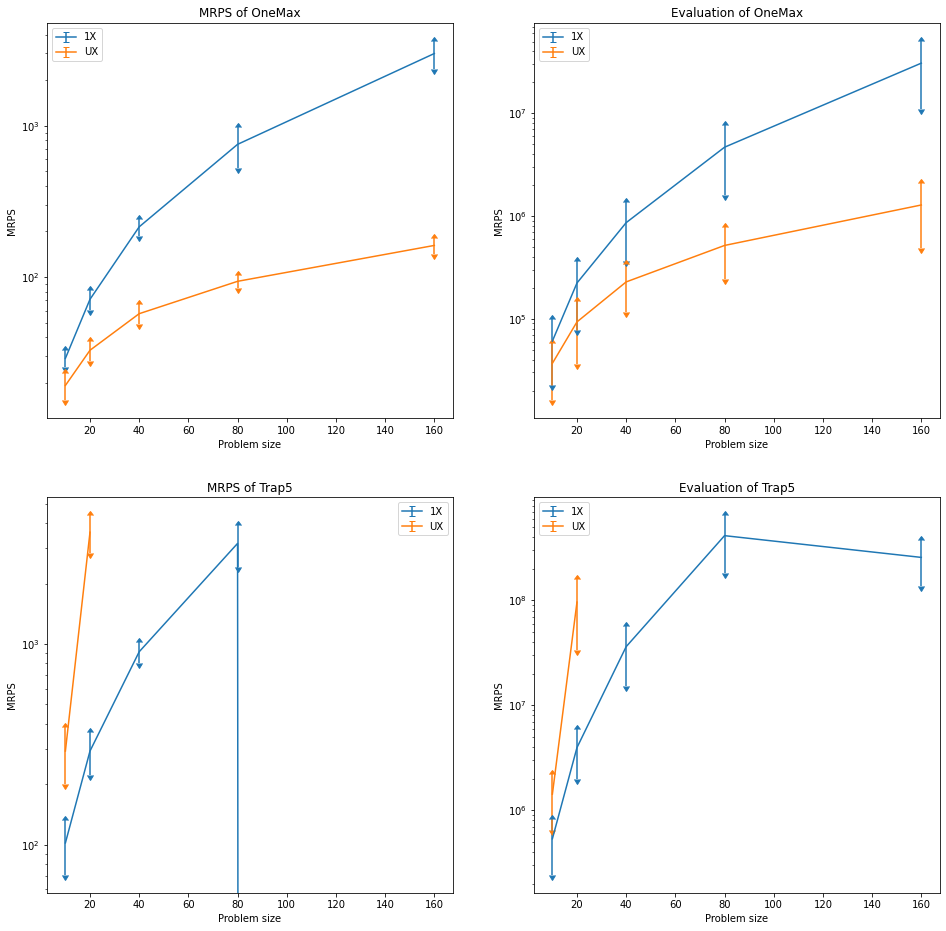

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

#onemax
ax = axs[0][0]
ax.errorbar(error_bar, onemax_y1X, yerr=onemax_y1X_sde, uplims=True, lolims=True, label='1X')
ax.errorbar(error_bar, onemax_yUX, yerr=onemax_yUX_sde, uplims=True, lolims=True, label='UX')

ax.set_yscale('log')
ax.set_xlabel('Problem size')
ax.set_ylabel('MRPS')
ax.set_title('MRPS of OneMax')
ax.legend()

ax = axs[0][1]
ax.errorbar(error_bar, onemax_eval_y1X, yerr=onemax_eval_1X_sde, uplims=True, lolims=True, label='1X')
ax.errorbar(error_bar, onemax_eval_yUX, yerr=onemax_eval_UX_sde, uplims=True, lolims=True, label='UX')

ax.set_yscale('log')
ax.set_xlabel('Problem size')
ax.set_ylabel('MRPS')
ax.set_title('Evaluation of OneMax')
ax.legend()


#Trap-5
ax = axs[1][0]
ax.errorbar(error_bar, trap5_y1X, yerr=trap5_y1X_sde, uplims=True, lolims=True, label='1X')
ax.errorbar(error_bar[:2], trap5_yUX[:2], yerr=trap5_yUX_sde[:2], uplims=True, lolims=True, label='UX')

ax.set_yscale('log')
ax.set_xlabel('Problem size')
ax.set_ylabel('MRPS')
ax.set_title('MRPS of Trap5')
ax.legend()

ax = axs[1][1]
ax.errorbar(error_bar, trap5_eval_y1X, yerr=trap5_eval_1X_sde, uplims=True, lolims=True, label='1X')
ax.errorbar(error_bar[:2], trap5_eval_yUX[:2], yerr=trap5_eval_UX_sde[:2], uplims=True, lolims=True, label='UX')

ax.set_yscale('log')
ax.set_xlabel('Problem size')
ax.set_ylabel('MRPS')
ax.set_title('Evaluation of Trap5')
ax.legend()

plt.show()

fig.savefig('/content/visualize_plot.png', dpi=fig.dpi)